# A XV Legislatura: os primeiros 6 meses

```{epigraph}
"O primeiro é breve, mas perigoso, atravessa vários obstáculos que só poderá evitar com muitíssimo trabalho; o outro mais largo, com margens, é plano e fácil se ajudar com magnetismo, não desvia nem à esquerda, nem à direita. O terceiro é certamente a via real: alguns prazeres e espetáculos de nosso Rei tornam seu caminho agradável. Mas apenas um dentre mil chegam por ele ao objetivo. Entretanto, pelo quarto nenhum homem pode chegar ao Palácio do Rei."

-- As Bodas Químicas de CR
```

## Os primeiros meses da XV legislatura

```{margin} Detalhes da análise
Esta análise vai cortar significativamente as explicações em torno do significado e métodos utilizados: são idênticos aos anteriores e podem ser explorados nas secções que descrevem em pormenor as opções tomadas, exemplos e referências.
```

As eleições legislativas realizadas em Janeiro de 2022 seguiram-se à dissolução da Assembleia da República, opção tomada pelo Presidente da República após a não aprovação do Orçamento de Estado para 2022. O governo minoritário do Partido Socialista governava desde 2015 com o apoio parlamentar dos partidos à sua esquerda, não tendo existido convergência suficient para assegurar a aprovação do Orçamento de Estado pelos votos contra de BE, PCP e PEV.

O resultado das eleições ditou uma maioria absoluta do PS, perdas substancias de BE, PCP e PAN, crescimento significativo de Chega e IL (ambos a constituirem grupo parlamentar), e a eleição de um deputado do Livre. CDS-PP não elege nenhum deputado, pela primeira vez, e PEV também não: ambos os partidos perdem a representação parlamentar.



In [1]:
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from IPython.core.display import display, HTML
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#sns.set(font="EB Garamond")
sns.set_theme(style="whitegrid", palette="pastel")
from myst_nb import glue
%matplotlib inline

In [2]:
## Get the data
from urllib.request import urlopen
import xml.etree.ElementTree as ET

#l13_ini_url = 'https://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379394a626d6c6a6157463061585a686379395953556c4a4a5449775447566e61584e7359585231636d45765357357059326c6864476c3259584e5953556c4a4c6e687462413d3d&fich=IniciativasXIII.xml&Inline=true'
#l13_ini_tree = ET.parse(urlopen(l13_ini_url))
l15_ini_url="https://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379394a626d6c6a6157463061585a6863793959566955794d45786c5a326c7a6247463064584a684c306c7561574e7059585270646d467a5746597565473173&fich=IniciativasXV.xml&Inline=true"

l15_ini_file="./l15.xml"
#l13_ini_file = './l13_ini.xml'
#l13_ini_tree = ET.parse(l13_ini_file)
#l14_ini_file = './l14_ini.xml'
#l14_ini_tree = ET.parse(l14_ini_file)
l15_ini_tree = ET.parse(urlopen(l15_ini_url))
#l15_ini_tree = ET.parse(l15_ini_file)

In [3]:
from bs4 import BeautifulSoup
import re
import pandas as pd

## Iteract through the existing dict
def party_from_votes (votes):
    """
    Determines the position of a party based on the majority position by summing all the individual votes.
    Argument is a dictionary returned by parse_voting()
    Returns a dictionary with the majority position of each party
    """
    party_vote = {}
    for k, v in votes.items():
        ## Erase the name of the MP and keep the party only
        ## only when it's not from the "Ninsc" group - 
        ## these need to be differentiated by name
        if re.match(".*\(Ninsc\)" , k) is None:
            nk = re.sub(r".*\((.+?)\).*", r"\1", k)
        else:
            nk = k
        ## If it's the first entry for a key, create it
        if nk not in party_vote:
            party_vote[nk] = [0,0,0]
        ## Add to a specific index in a list
        if v == "A Favor":
            party_vote[nk][0] += 1
        elif v == "Abstenção":
            party_vote[nk][1] += 1
        elif v == "Contra":
            party_vote[nk][2] += 1
    for k,v in party_vote.items():
        party_vote[k]=["A Favor", "Abstenção", "Contra"][v.index(max(v))]
    return party_vote

def parse_voting(v_str):
    """Parses the voting details in a string and returns a dict.
    
    Keyword arguments:
    
    v_str: a string with the description of the voting behaviour.
    """
    ## Split by the HTML line break and put it in a dict
    d = dict(x.split(':') for x in v_str.split('<BR>'))
    ## Remove the HTML tags
    for k, v in d.items():
        ctext = BeautifulSoup(v, "lxml")
        d[k] = ctext.get_text().strip().split(",")
    ## Invert the dict to get a 1-to-1 mapping
    ## and trim it
    votes = {}
    if len(v_str) < 1000:    # Naive approach but realistically speaking... works well enough.
        for k, v in d.items():
            for p in v:
                if (p != ' ' and                                       # Bypass empty entries
                    re.match("[0-9]+", p.strip()) is None and           # Bypass quantified divergent voting patterns
                    (re.match(".*\w +\(.+\)", p.strip()) is None or     # Bypass individual votes...
                     re.match(".*\(Ninsc\)" , p.strip()) is not None)): # ... except when coming from "Ninsc"
                        #print("|"+ p.strip() + "|" + ":\t" + k)
                        votes[p.strip()] = k
    else:  # This is a nominal vote since the size of the string is greater than 1000
        for k, v in d.items():
            for p in v:
                if p != ' ':
                    votes[p.strip()] = k
        ## Call the auxiliary function to produce the party position based on the majority votes
        votes = party_from_votes(votes)
    return votes

In [4]:
import collections

def ini_to_df(root):
    counter=0

    ## We will build a dataframe from a list of dicts
    ## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
    init_list = []

    for voting in root.findall(".//pt_gov_ar_objectos_VotacaoOut"):
        votep = voting.find('./detalhe')
        if votep is not None:
            init_dict = collections.OrderedDict()
            counter +=1                 
            init_dict['id'] = voting.find('id').text
            ## Add the "I" for Type to mark this as coming from "Iniciativas"
            init_dict['Tipo'] = "I"
            for c in voting:
                if c.tag == "detalhe":
                    for party, vote in parse_voting(c.text).items():
                        init_dict[party] = vote 
                elif c.tag == "descricao":
                        init_dict[c.tag] = c.text
                elif c.tag == "ausencias":
                        init_dict[c.tag] = c.find("string").text
                else:
                        init_dict[c.tag] = c.text
            init_list.append(init_dict)
        ## Provide progression feedback
        #print('.', end='')
    return pd.DataFrame(init_list)
        
#print(counter)

In [5]:

def ini_to_df_ini(root):
    counter=0

    ## We will build a dataframe from a list of dicts
    ## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
    init_list = []

    for ini in root.findall("pt_gov_ar_objectos_iniciativas_DetalhePesquisaIniciativasOut"):
        for evento in ini.iter("pt_gov_ar_objectos_iniciativas_EventosOut"):
            for voting in evento.iter("pt_gov_ar_objectos_VotacaoOut"):
                votep = voting.find('./detalhe')
                if votep is not None:
                    init_dict = collections.OrderedDict()
                    counter +=1
                    init_dict["fase"] = evento.find("fase").text
                    for c in ini:
                        if c.tag == "iniAutorGruposParlamentares" or c.tag == "iniAutorDeputados":
                            if c.find('pt_gov_ar_objectos_AutoresGruposParlamentaresOut/GP') is not None:
                                init_dict[c.tag] = c.find('pt_gov_ar_objectos_AutoresGruposParlamentaresOut/GP').text
                            elif c.find('pt_gov_ar_objectos_iniciativas_AutoresDeputadosOut/GP').text == "Ninsc":
                                init_dict["iniAutorGruposParlamentares"] = c.find('pt_gov_ar_objectos_iniciativas_AutoresDeputadosOut/nome').text
                        else:
                            init_dict[c.tag] = c.text
                    counter +=1                 
                    init_dict['id'] = voting.find('id').text
                    ## Add the "I" for Type to mark this as coming from "Iniciativas"
                    init_dict['Tipo'] = "I"
                    for c in voting:
                        if c.tag == "detalhe":
                            for party, vote in parse_voting(c.text).items():
                                init_dict[party] = vote 
                        elif c.tag == "descricao":
                                init_dict[c.tag] = c.text
                        elif c.tag == "ausencias":
                                init_dict[c.tag] = c.find("string").text
                        else:
                                init_dict[c.tag] = c.text
                    init_list.append(init_dict)
            ## Provide progression feedback
        #print('.', end='')
    print(counter)
    return pd.DataFrame(init_list)
        


In [6]:
l15a = ini_to_df_ini(l15_ini_tree)

2592


In [7]:
l15_parties = ['BE', 'PCP', 'L','PS', 'PAN','PSD','IL', 'CH']
votes = l15a
parties = l15_parties
votes['data']= pd.to_datetime(votes['data'])
votes['ano'] = pd.DatetimeIndex(votes['data']).year
votes['leg'] = 15
votes_hm=votes[l15_parties]
votes_nu = votes[votes["unanime"] != "unanime"]
votes_nu_hm=votes_nu[l15_parties]
min_date=min(votes["data"])
max_date=max(votes["data"])

```{margin} Estatísticas base
Os dados essenciais do ficheiro XML importado são as seguintes:
```

In [8]:
from datetime import datetime
from IPython.display import display, Markdown, Latex


display(Markdown("*Total de votações:* {}".format(votes.shape[0])))
display(Markdown("*Data limite inferior:* {}".format(datetime.date(min_date))))
display(Markdown("*Data limite superior:* {}".format(datetime.date(max_date))))



*Total de votações:* 1296

*Data limite inferior:* 2022-04-22

*Data limite superior:* 2023-04-28

O processamento inicial resulta num conjunto bastante alargado de colunas e observações (votações, uma por linha), nomeadamente os votos dos vários partidos.

In [9]:
with pd.option_context("display.max_columns", 0):
    display(votes[["resultado", "id"] + parties])

,resultado,id,BE,PCP,L,PS,PAN,PSD,IL,CH
0,Rejeitado,104126,Contra,A Favor,A Favor,Contra,A Favor,A Favor,A Favor,Contra
1,Aprovado,104127,A Favor,Abstenção,A Favor,Abstenção,A Favor,A Favor,A Favor,A Favor
2,Rejeitado,104125,Abstenção,Contra,Abstenção,Contra,A Favor,A Favor,A Favor,A Favor
3,Rejeitado,103755,Contra,Contra,Contra,Contra,Abstenção,Abstenção,A Favor,A Favor
4,Rejeitado,103678,Abstenção,Abstenção,Contra,Contra,Contra,Abstenção,A Favor,A Favor
...,...,...,...,...,...,...,...,...,...,...
1291,Aprovado,104535,Contra,Contra,Contra,A Favor,Abstenção,A Favor,A Favor,A Favor
1292,Aprovado,103492,Abstenção,Abstenção,A Favor,A Favor,Abstenção,A Favor,A Favor,A Favor
1293,Aprovado,103318,Contra,Contra,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor
1294,Aprovado,103317,Contra,Contra,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor


## Mapa térmico das votações

O mapa térmico de votações para a legislatura -- recordemos que nos permite ver através de cores todas as votações, dando uma imagem geral do comportamento dos vários partidos -- é o seguinte:

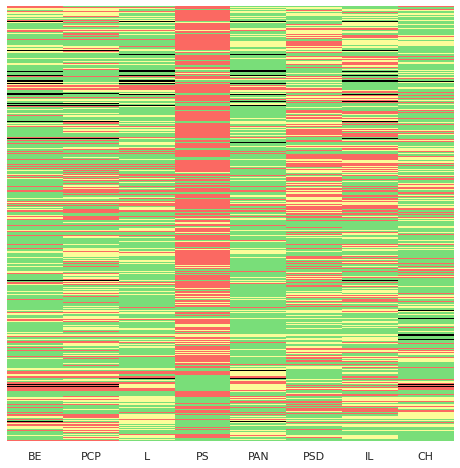

In [10]:
votes_hmn = votes_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,-2]).fillna(0)

##RYG
voting_palette = ["black","#FB6962","#FCFC99","#79DE79",]

fig = plt.figure(figsize=(8,8))
sns.heatmap(votes_hmn ,
            square=False,
            yticklabels = False,
            cbar=False,
            cmap=sns.color_palette(voting_palette),
            linewidths=0,
           )
plt.show()

## Votações idênticas

Das votações da legislatura é esta a matriz de votações idênticas:

In [11]:
pv_list = []
def highlight_diag(df):
    a = np.full(df.shape, '', dtype='<U24')
    np.fill_diagonal(a, 'font-weight: bold;')
    return pd.DataFrame(a, index=df.index, columns=df.columns)

## Not necessarily the most straightforard way (check .crosstab or .pivot_table, possibly with pandas.melt and/or groupby)
## but follows the same approach as before in using a list of dicts
for party in votes_hm.columns:
    pv_dict = collections.OrderedDict()
    for column in votes_hmn:
        pv_dict[column]=votes_hmn[votes_hmn[party] == votes_hmn[column]].shape[0]
    pv_list.append(pv_dict)

pv = pd.DataFrame(pv_list,index=votes_hm.columns)
pv.style.apply(highlight_diag, axis=None)

,BE,PCP,L,PS,PAN,PSD,IL,CH
BE,1296,846,975,355,879,468,502,521
PCP,846,1296,807,405,625,509,422,459
L,975,807,1296,366,927,452,501,445
PS,355,405,366,1296,300,570,443,335
PAN,879,625,927,300,1296,464,529,535
PSD,468,509,452,570,464,1296,706,651
IL,502,422,501,443,529,706,1296,603
CH,521,459,445,335,535,651,603,1296


```{margin} Votos idênticos vs. distância de votos
Este quadro parece ser um dos mais populares, talvez por ser muito directo na mensagem que transmite. Por isso mesmo fica a nota: a consideração apenas dos votos "idênticos" desconsidera completamente a diferença entre votar Contra e Abstenção. Esta dimensão irá ser capturada na matriz de distâncias.
```

A visualização desta matriz através de um mapa térmico:

```{margin} Votos unânimes
Removendo os votos unânimes pode-se obter um mapa térmico semelhante, mas com uma escala diferente. Não há alteração substantiva ao anterior, nem a remoção dos votos unânimes altera as distâncias.

```

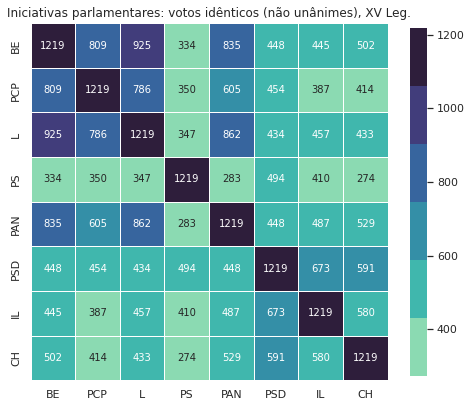

In [12]:
pv_nu_list = []
votes_nu_hmn = votes_nu_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,-2]).fillna(0)

## Not necessarily the most straightforard way (check .crosstab or .pivot_table, possibly with pandas.melt and/or groupby)
## but follows the same approach as before in using a list of dicts
for party in votes_nu_hm.columns:
    pv_dict = collections.OrderedDict()
    for column in votes_nu_hmn:
        pv_dict[column]=votes_nu_hmn[votes_nu_hmn[party] == votes_nu_hmn[column]].shape[0]
    pv_nu_list.append(pv_dict)

pv_nu = pd.DataFrame(pv_nu_list,index=votes_nu_hm.columns)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

sns.heatmap(
    pv_nu,
    cmap=sns.color_palette("mako_r"),
    linewidth=1,
    annot = True,
    square =True,
    fmt="d",
    cbar_kws={"shrink": 0.8})
plt.title('Iniciativas parlamentares: votos idênticos (não unânimes), XV Leg.')

plt.show()

```{margin}
A tabela respectiva (observe-se o menor número de votações consideradas, dada a remoção das unânimes)
```

In [13]:
pv_nu.style.apply(highlight_diag, axis=None)

,BE,PCP,L,PS,PAN,PSD,IL,CH
BE,1219,809,925,334,835,448,445,502
PCP,809,1219,786,350,605,454,387,414
L,925,786,1219,347,862,434,457,433
PS,334,350,347,1219,283,494,410,274
PAN,835,605,862,283,1219,448,487,529
PSD,448,454,434,494,448,1219,673,591
IL,445,387,457,410,487,673,1219,580
CH,502,414,433,274,529,591,580,1219


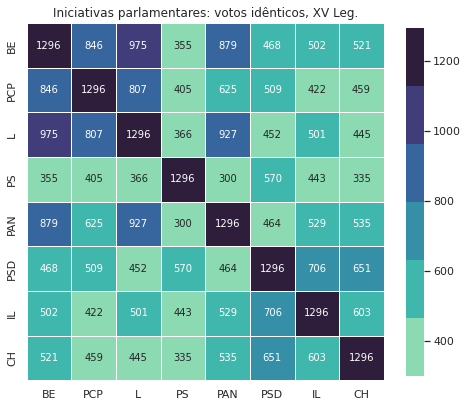

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

sns.heatmap(
    pv,
    cmap=sns.color_palette("mako_r"),
    linewidth=1,
    annot = True,
    square =True,
    fmt="d",
    cbar_kws={"shrink": 0.8})
plt.title('Iniciativas parlamentares: votos idênticos, XV Leg.')

plt.show()

## Matriz de distância e dendograma

Considerando a distância entre os votos (onde um voto a favor está mais perto de uma abstenção do que de um voto contra) obtemos o seguinte `clustermap` que conjuga a visualização da matriz de distância com o dendograma: como se relacionam os partidos e como se agrupam com base nos seus votos.

In [15]:
## Change the mapping, we now consider Abst and Aus the same
votes_hmn = votes_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)

## Transpose the dataframe used for the heatmap
votes_t = votes_hmn.transpose()

## Determine the Eucledian pairwise distance
## ("euclidean" is actually the default option)
pwdist = pdist(votes_t, metric='euclidean')

## Create a square dataframe with the pairwise distances: the distance matrix
distmat = pd.DataFrame(
    squareform(pwdist), # pass a symmetric distance matrix
    columns = votes_t.index,
    index = votes_t.index
)
#show(distmat, scrollY="200px", scrollCollapse=True, paging=False)

## Normalise by scaling between 0-1, using dataframe max value to keep the symmetry.
## This is essentially a cosmetic step
#distmat=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
    
distmat.style.apply(highlight_diag, axis=None)

,BE,PCP,L,PS,PAN,PSD,IL,CH
BE,0.000000,27.037012,19.519221,52.345009,24.677925,43.852024,42.544095,40.607881
PCP,27.037012,0.000000,28.774989,48.631266,34.496377,41.593269,44.079474,41.109610
L,19.519221,28.774989,0.000000,50.229473,21.260292,42.848571,41.629317,40.914545
PS,52.345009,48.631266,50.229473,0.000000,52.905576,41.388404,45.276926,51.584882
PAN,24.677925,34.496377,21.260292,52.905576,0.000000,41.665333,39.635842,37.735925
PSD,43.852024,41.593269,42.848571,41.388404,41.665333,0.000000,30.903074,32.710854
IL,42.544095,44.079474,41.629317,45.276926,39.635842,30.903074,0.000000,34.713110
CH,40.607881,41.109610,40.914545,51.584882,37.735925,32.710854,34.713110,0.000000


O _clustermap_ inclui os resultados do agrupamentos pelo método de Ward, com base nas distâncias acima:

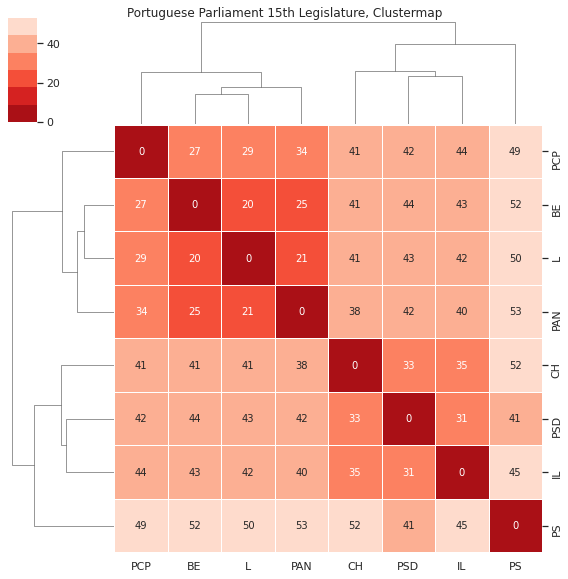

In [16]:
## Perform hierarchical linkage on the distance matrix using Ward's method.
distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True )

sns.clustermap(
    distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    #standard_scale=1,
    row_linkage=distmat_link,
    col_linkage=distmat_link,
    figsize=(8,8)).fig.suptitle('Portuguese Parliament 15th Legislature, Clustermap',y=1)
plt.show()

```{margin}
O dendograma respectivo é este, e como se vê é exactamente o mesmo que o apresentado no _clustermap_
```

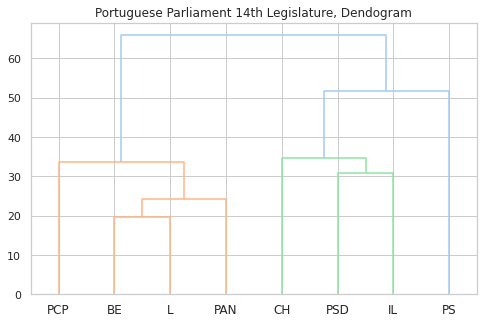

In [17]:
from scipy.cluster.hierarchy import dendrogram
fig = plt.figure(figsize=(8,5))
dendrogram(distmat_link, labels=votes_hmn.columns)

plt.title("Portuguese Parliament 14th Legislature, Dendogram")
plt.show()

O agrupamento, também derivado do número de partidos, tem diferenças óbvias em relação ao da XIII legislatura: por um lado o posicionamento do PS, por outro a forma como os novos partidos se agrupam (entre si, e com os que já tinham representam).

## _Clustering_ de observações: _Spectrum Scaling_

Uma forma diferente de determinar agrupamentos é através de métodos de _clustering_, que procuram determinar agrupamentos de pontos com base em mecanismos específicos de cada um dos algoritmos.

In [18]:
distmat_mm=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
#pd.DataFrame(distmat_mm, distmat.index, distmat.columns)
affinmat_mm = pd.DataFrame(1-distmat_mm, distmat.index, distmat.columns)
affinmat_mm.style.apply(highlight_diag, axis=None)

,BE,PCP,L,PS,PAN,PSD,IL,CH
BE,1.000000,0.488957,0.631056,0.010596,0.533548,0.171127,0.195849,0.232446
PCP,0.488957,1.000000,0.456107,0.080791,0.347963,0.213821,0.166827,0.222963
L,0.631056,0.456107,1.000000,0.050583,0.598146,0.190093,0.213139,0.226650
PS,0.010596,0.080791,0.050583,1.000000,0.000000,0.217693,0.144194,0.024963
PAN,0.533548,0.347963,0.598146,0.000000,1.000000,0.212459,0.250819,0.286731
PSD,0.171127,0.213821,0.190093,0.217693,0.212459,1.000000,0.415882,0.381713
IL,0.195849,0.166827,0.213139,0.144194,0.250819,0.415882,1.000000,0.343867
CH,0.232446,0.222963,0.226650,0.024963,0.286731,0.381713,0.343867,1.000000


```{margin}
A matriz de afinidade normalizada pode ser vizualizada de forma semelhante à de distância; como está normalizada e numa escala $ 0 - 1 $ podem-se considerar os valores uma percentagem de afinidade. É importante considerar que, dado o processo de normalização, os valores apresentados ampliam as diferenças.
```

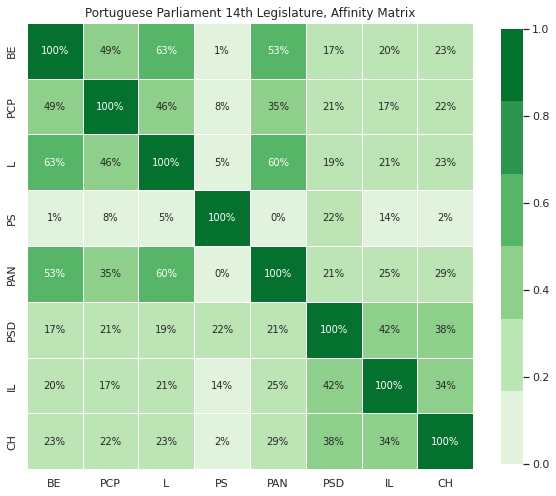

In [19]:
## Make the top triangle
mask = np.triu(np.ones_like(affinmat_mm, dtype=bool))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
plt.title('Portuguese Parliament 14th Legislature, Affinity Matrix')

## Display the heatmap of the affinity matrix, masking the top triangle

sns.heatmap(
    affinmat_mm,
    cmap=sns.color_palette("Greens"),
    linewidth=1,
    fmt=".0%",
    annot = True,
    square =True,
    cbar_kws={"shrink": .8},
    #mask=mask,linewidths=.5
)

plt.show()

 _Spectral Clustering_ é uma forma de _clustering_ que utiliza os valores-próprios e vectores-próprios de matrizes como forma de determinação dos grupos. Este método necessita que seja determinado _a priori_ o número de _clusters_; assim, podemos usar este método para agrupamentos mais finos.

In [20]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(4, affinity="precomputed",random_state=2020).fit_predict(affinmat_mm)
sc_dict = dict(zip(distmat,sc))

pd.DataFrame.from_dict(sc_dict, orient='index', columns=["Group"]).T

,BE,PCP,L,PS,PAN,PSD,IL,CH
Group,1,3,1,0,1,2,2,2


### _Multidimensional scaling_ 

Não temos ainda uma forma de visualizar a distância relativa de cada partido em relação aos outros com base nas distâncias/semelhanças: temos algo próximo com base no dendograma mas existem outras formas de visualização interessantes.

Uma das formas é o _multidimensional scaling_ que permite visualizar a distância ao projectar em 2 ou 3 dimensões (também conhecidas como _dimensões visualizavies_) conjuntos multidimensionais, mantendo a distância relativa {cite}`GraphicalRepresentationProximity`. Juntando à representação cores que representam o agrupamento feito por _Spectrum Clustering_ temos o seguinte resultado:

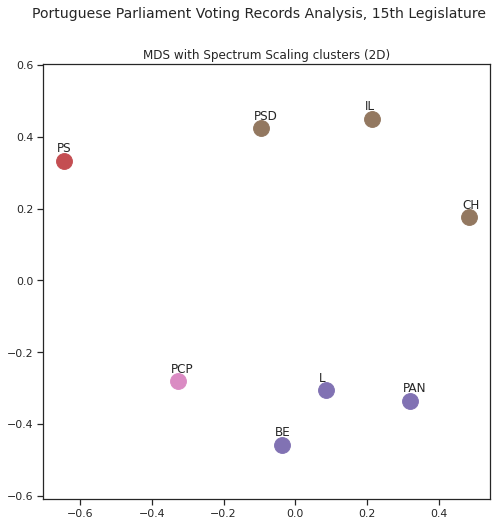

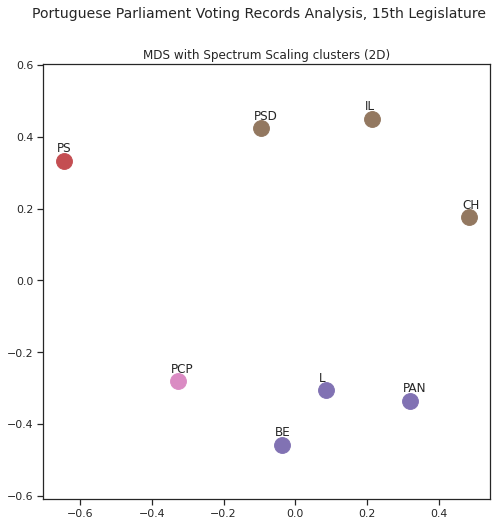

In [21]:
from sklearn.manifold import MDS
import random


mds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)
## We use the normalised distance matrix but results would
## be similar with the original one, just with a different scale/axis
results = mds.fit(distmat_mm.values)
coords = results.embedding_

sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Portuguese Parliament Voting Records Analysis, 15th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (2D)')


for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(sc_dict[label]+3
                                ), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))

plt.show()
glue("mds_15", fig, display=False)

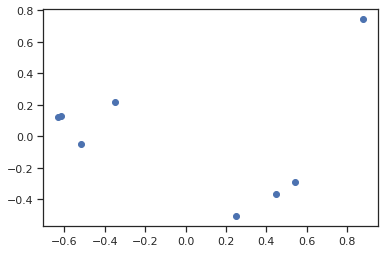

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Xt = pca.fit_transform(distmat_mm.values)
plot = plt.scatter(Xt[:,0], Xt[:,1])
plt.show()

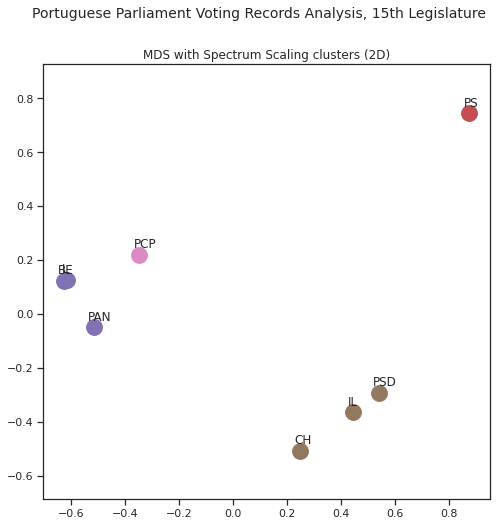

In [23]:
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2,random_state=1020)
Xt = pca.fit_transform(distmat_mm.values)

sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Portuguese Parliament Voting Records Analysis, 15th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (2D)')
for label, x, y in zip(distmat_mm.columns, Xt[:, 0], Xt[:, 1]):
    ax.scatter(x, y, c = "C"+str(sc_dict[label]+3
                                ), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))

plt.show()

Por último, o mesmo MDS em 3D, e em forma interactiva:

In [24]:
for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    print(label,x,y)

BE -0.036637507515075954 -0.4574887074224129
PCP -0.3269512417062744 -0.28118405611212594
L 0.08574362769458113 -0.3063221928609414
PS -0.6454513021313442 0.33273788185934744
PAN 0.320449782647986 -0.33534765245637316
PSD -0.09555489101875213 0.42298370292062715
IL 0.21384796641506224 0.4491706452872633
CH 0.48455356561381724 0.1754503787846154


In [25]:
mds = MDS(n_components=3, dissimilarity='precomputed',random_state=1234, n_init=100, max_iter=1000)
results = mds.fit(distmat.values)
parties = distmat.columns
coords = results.embedding_
import plotly.graph_objects as go
# Create figure
fig = go.Figure()

# Loop df columns and plot columns to the figure
for label, x, y, z in zip(parties, coords[:, 0], coords[:, 1], coords[:, 2]):
    fig.add_trace(go.Scatter3d(x=[x], y=[y], z=[z],
                        text=label,
                        textposition="top center",
                        mode='markers+text', # 'lines' or 'markers'
                        name=label))
fig.update_layout(
    width = 1000,
    height = 1000,
    title = "15th Legislature: 3D MDS",
    template="plotly_white",
    showlegend=False
)
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
plot(fig, filename = 'l15-3d-mds.html')
display(HTML('l15-3d-mds.html'))

TypeError: 'PathCollection' object is not callable

## Propostas apresentadas: quem aprova as propostas de quem.

Utilizámos a mesma abordagem já detalhada em pormenor em análises da XIV legislatura, para a qual remetemos para mais detalhes. De forma resumida, a análise é feito com base nas propostas votadas na generalidade - e apenas essas - e das quais se obtem o partido que apresenta a iniciativa, e os votos dos restantes.

In [61]:
#votes_hm=votes[l14_parties]
l15af = l15a[l15a["fase"] == "Votação na generalidade"]
l15af["GP"] = l15af["iniAutorGruposParlamentares"]
l15af = l15af[l15af["GP"].notna()]

/tmp/ipykernel_101402/2110910231.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [62]:
l15a.columns

Index(['fase', 'iniNr', 'iniTipo', 'iniDescTipo', 'iniLeg', 'iniSel',
       'dataInicioleg', 'iniTitulo', 'iniTextoSubst', 'iniLinkTexto',
       'iniEventos', 'iniAutorOutros', 'iniId', 'iniAutorGruposParlamentares',
       'id', 'Tipo', 'resultado', 'descricao', 'reuniao', 'tipoReuniao', 'PSD',
       'IL', 'PCP', 'PAN', 'L', 'PS', 'CH', 'BE', 'data', 'iniTextoSubstCampo',
       'iniAnexos', 'peticoes', 'unanime', 'ausencias', '5-PSD', '7-PS',
       '63-PSD', '4-PS', '2-PSD', '6-PSD', '6-PS', '58-PSD', '1-PS', '3-PSD',
       '5-PS', '1-PSD', 'publicacao', 'ano', 'leg'],
      dtype='object')

O total de propostas votadas na generalidade, com a identificação das aprovadas e rejeitadas, é o seguinte:

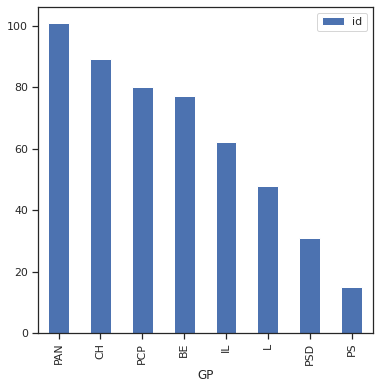

In [63]:
l15af.groupby('GP')[['id']].count().sort_values(by=['id'], axis=0, ascending=False).plot(kind="bar",stacked=True,figsize=(6,6))
plt.show()

```{margin}
Em formato tabular, com os totais.
```

In [64]:
ct = pd.crosstab(l15af.GP, l15af.resultado)
ct["Total"] = ct["Aprovado"] + ct["Rejeitado"]
ct.sort_values(by=['Total'], axis=0, ascending=False)

resultado,Aprovado,Rejeitado,Total
GP,,,
PAN,17,84,101
CH,0,89,89
PCP,3,77,80
BE,5,72,77
IL,10,52,62
L,11,37,48
PSD,11,20,31
PS,15,0,15


Podemos também visualizar a quantidade de propostas aprovadas e rejeitadas:

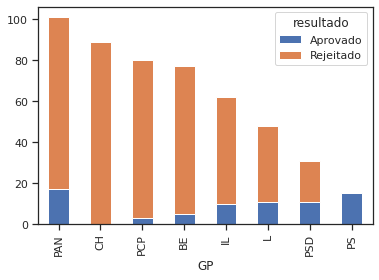

In [65]:
ct.sort_values(by=['Total'], axis=0, ascending=False).drop("Total", axis=1).plot(kind="bar", stacked=True)
plt.show()

Com esta informação, e de forma muito semelhante à utilizada para determinar os apoios às propostas de alteração do Orçamento de Estado, é possível determinar os padrões de votação; o diagrama seguinte mostra a relação entre cada par de partidos: no eixo horizontal quem propõe, e no vertical como votaram:

In [66]:
mycol  = ['GP', 'BE', 'PCP', 'L','PS', 'PAN','PSD','IL', 'CH' ]
df=l15af
submissions_ini = df[mycol]
submissions_ini.head()

,GP,BE,PCP,L,PS,PAN,PSD,IL,CH
10,L,A Favor,A Favor,A Favor,Contra,A Favor,Contra,Abstenção,Abstenção
11,IL,Contra,Contra,Contra,Contra,A Favor,A Favor,A Favor,Abstenção
12,PSD,Contra,Contra,Contra,Contra,A Favor,A Favor,A Favor,Abstenção
13,PS,A Favor,Abstenção,A Favor,A Favor,A Favor,A Favor,A Favor,A Favor
14,PCP,A Favor,A Favor,A Favor,Contra,Abstenção,Contra,Abstenção,A Favor


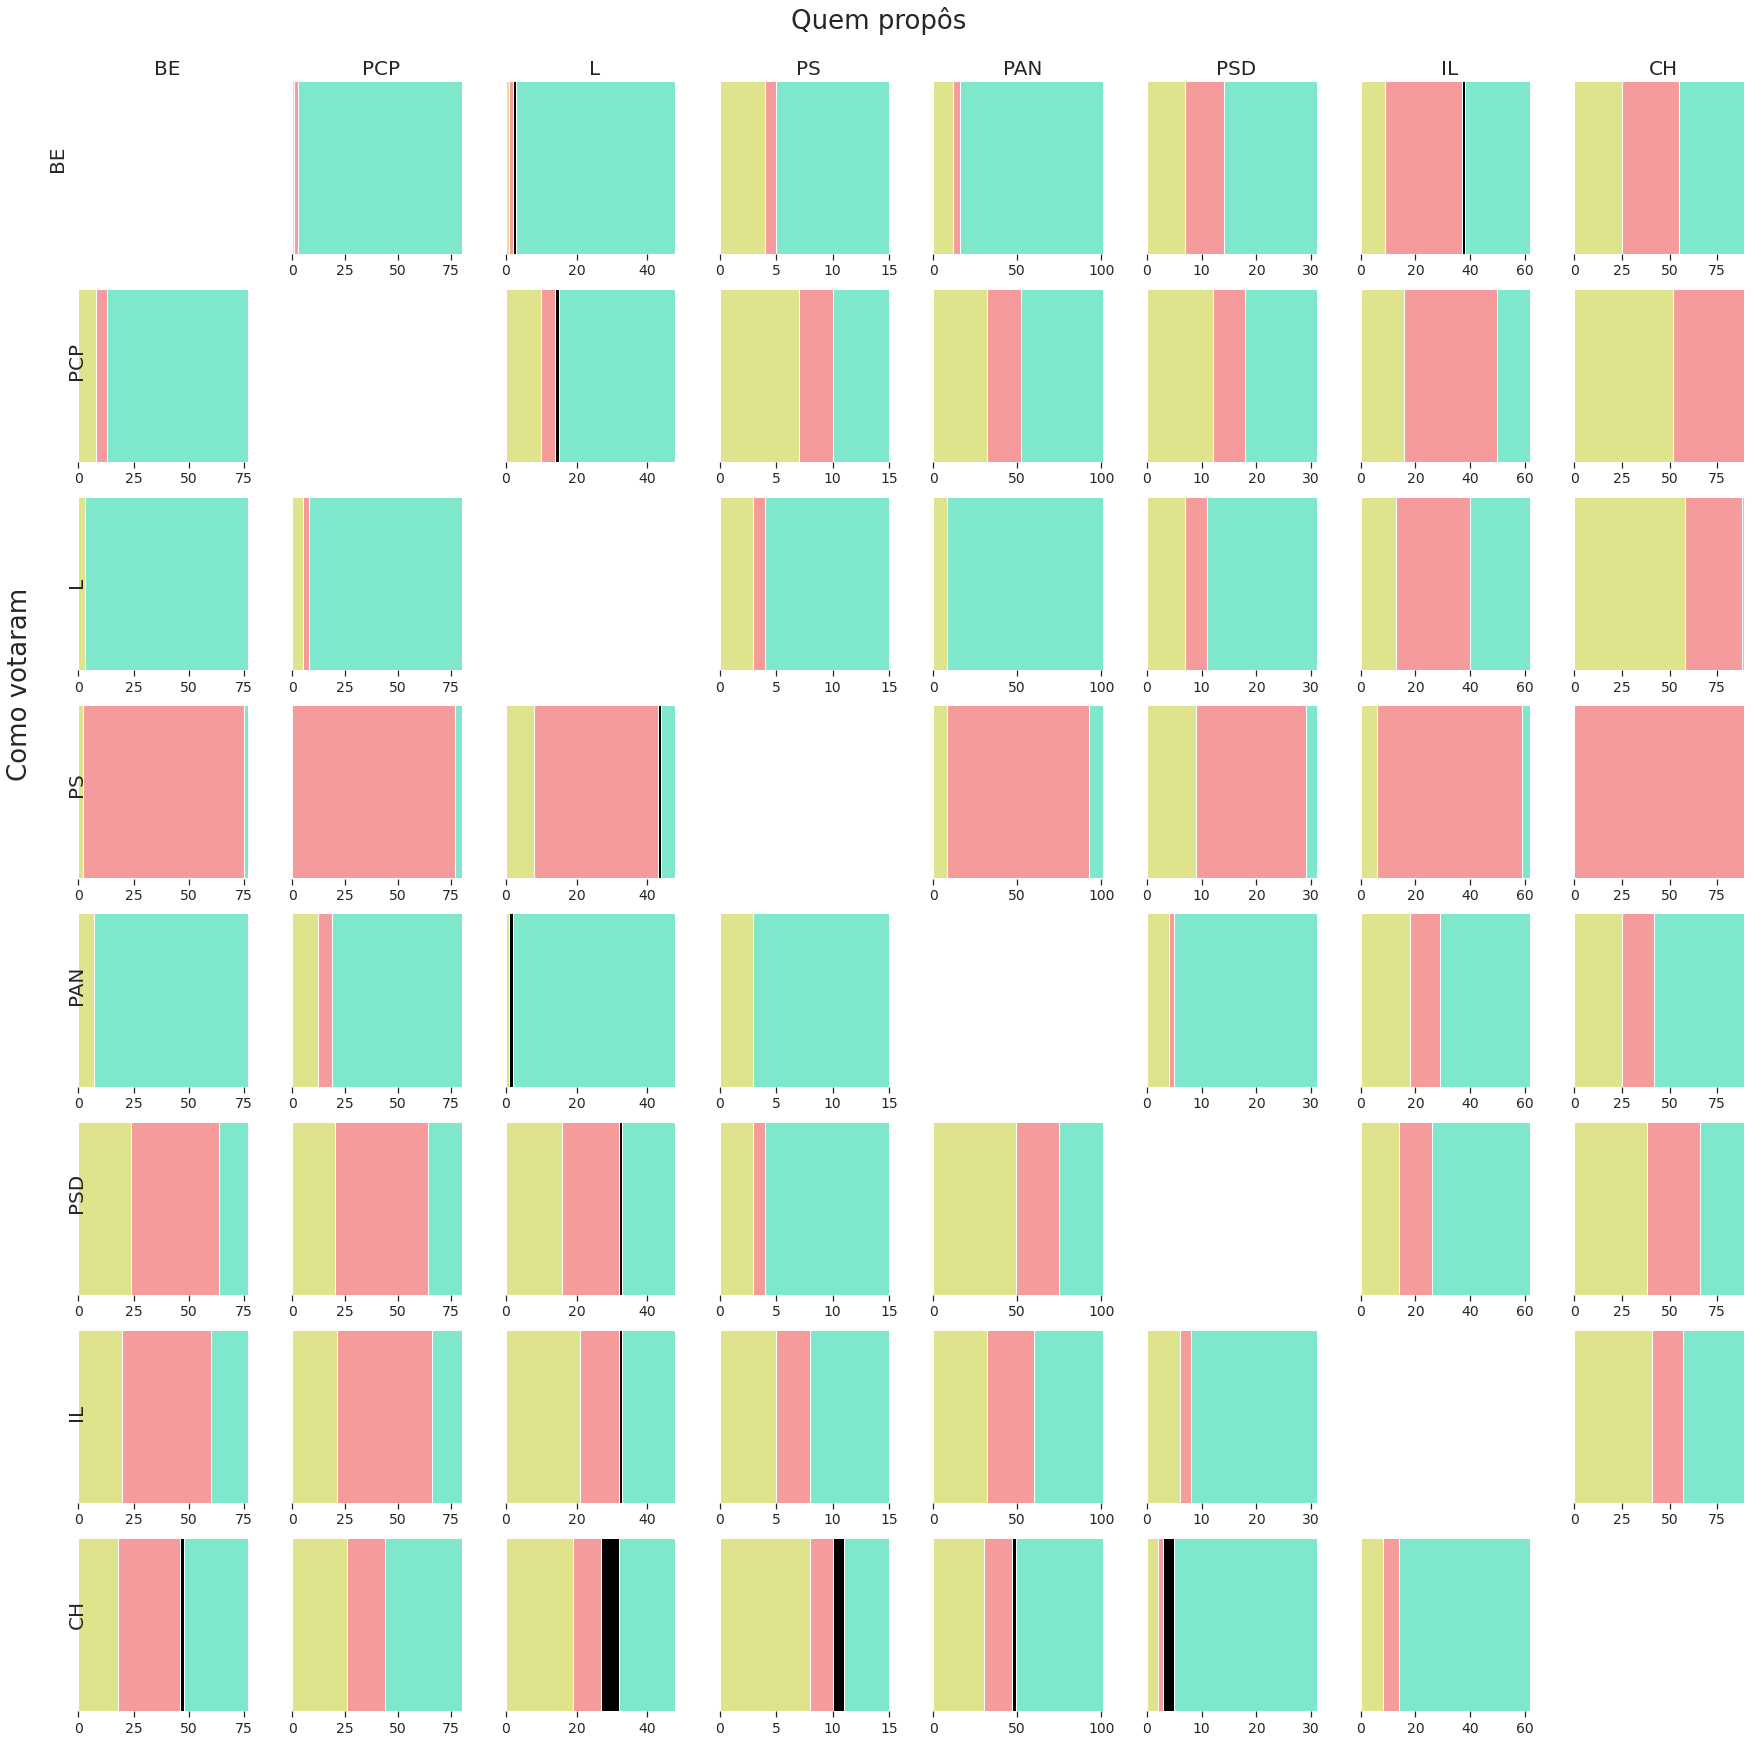

In [67]:
import seaborn as sns
from matplotlib.colors import ListedColormap
#parties   = ['BE', 'PCP', 'PEV', 'PS', 'L', 'PAN','PSD','IL','CDS-PP', 'CH']
#parties   = ['BE', 'PCP','PS', 'PAN','PSD','IL','CDS-PP', 'CH']
parties = ['BE', 'PCP', 'L', 'PS', 'PAN','PSD','IL', 'CH' ]
gpsubs = submissions_ini

cmap=ListedColormap(sns.color_palette("pastel").as_hex())
colors=["#DFE38C","#F59B9B","black","#7FE7CC" ]
cmap = ListedColormap(colors)

spn = 0
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(30, 30))
axes = axes.ravel()
plt.rcParams.update({'font.size': 22})

for party in parties:
    for p2 in parties:
        sns.set_style("white")
        subp = gpsubs[gpsubs['GP'] == p2][[party]]
        sp = subp.fillna("Ausência").apply(pd.Series.value_counts)
        d = pd.DataFrame(columns=["GP","Abstenção", "Contra", "Ausência","A Favor"]).merge(sp.T, how="right").fillna(0)
        d["GP"] = party
        d = d.set_index("GP")
        d = d[["Abstenção", "Contra", "Ausência","A Favor"]]
        if p2 != party:
            sns.despine(left=True, bottom=True)
            if spn < 8:
                d.plot(kind='barh', stacked=True,width=400,colormap=cmap, title=p2,use_index=False,ax=axes[spn], fontsize=12)
                axes[spn].title.set_size(20)
            else:
                d.plot(kind='barh', stacked=True,width=400,colormap=cmap,use_index=False,ax=axes[spn])
            axes[spn].get_legend().remove()
            plt.ylim(-4.5, axes[spn].get_yticks()[-1] + 0.5)
            axes[spn].tick_params(labelsize=14)

        else:
            axes[spn].set_xticks([])
            #d.plot(kind='barh', stacked=True,width=400,colormap=cmap,use_index=False,ax=axes[spn])
            #axes[spn].get_legend().remove()
            if spn < 7:
                axes[spn].set_title(p2, fontsize=20)
        axes[spn].set_yticks([])
        ## Why? Who knows? Certainly not me. This is likely a side-effect of using a single axis through .ravel
        if spn%8 == 0:
            if spn != 0:
                text = axes[spn].text(-5,0,party,rotation=90, fontsize=20)
            else:
                text = axes[spn].text(-0.17,0.5,party,rotation=90,fontsize=20)
        #print(party, p2)
        #print(d)
        #print("-------------------------_")
        spn += 1

#axes[11].set_axis_off()
text = axes[0].text(4,1.3,"Quem propôs",rotation=0,fontsize=26)
text = axes[0].text(-0.4,-3,"Como votaram",rotation=90,fontsize=26)

#fig.tight_layout()
plt.show()

Uma outra visualização que foca cada gráfico nas propostas de cada partido, e como votaram os restantes:

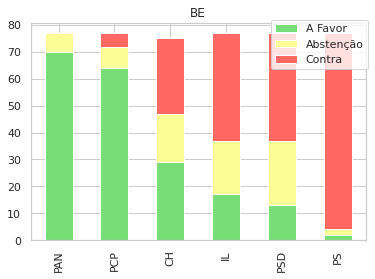

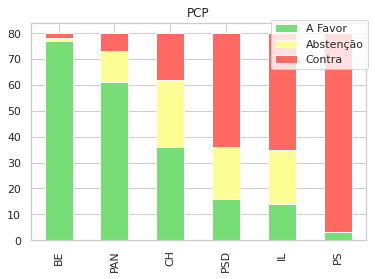

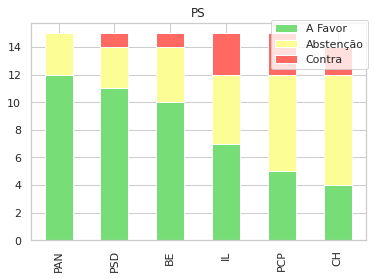

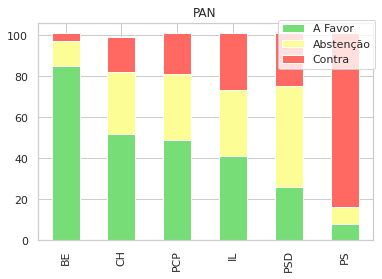

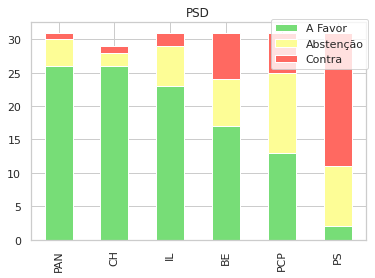

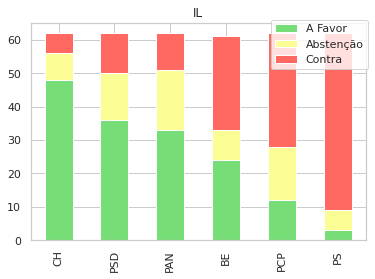

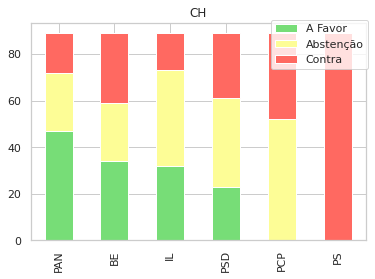

In [68]:
from IPython.display import display
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import cm
parties   = ['BE', 'PCP', 'PEV', 'PS'
             , 'PAN','PSD','IL','CDS-PP', 'CH']
parties = ['BE', 'PCP', 'PS', 'PAN','PSD','IL', 'CH' ]

ndf = pd.DataFrame()
#submissions_ini_nu = submissions_ini.loc[submissions_ini['unanime'] != "unanime"]
gpsubs = submissions_ini
cmap=ListedColormap(sns.color_palette("pastel").as_hex())
colors=["#77dd77","#fdfd96","#ff6961",  ]
cmap = ListedColormap(colors)

#spn = 0
#axes = axes.ravel()

for party in parties:
    sns.set_style("whitegrid")
    subp = gpsubs[gpsubs['GP'] == party]
    sp = subp[parties].apply(pd.Series.value_counts).fillna(0).drop([party],axis=1)
    sp = sp.sort_values(by=['A Favor','Abstenção','Contra'], ascending=False, axis=1)
    d = sp.T
    f = plt.figure()
    plt.title(party)
    d.plot(kind='bar', ax=f.gca(), stacked=True, title=party, colormap=cmap,)
    plt.legend(loc='center left',  bbox_to_anchor=(0.7, 0.9),)
    plt.show()
    #print(d)

plt.show()

## Análise

TBD




In [35]:
lpcp = l15af[l15af["GP"] == "CH"]
with pd.option_context("display.max_colwidth", -1):
    display(lpcp[lpcp["PS"] == "A Favor"][["iniTitulo"]])


,iniTitulo


In [70]:
lch = l15af[l15af["GP"] == "CH"]
lch.sort_values(by='data', inplace = True) 

/home/frmuno/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [78]:
with pd.option_context("display.max_colwidth", -1,"display.max_columns", None, "display.max_rows", None):
    display(lch[lch["BE"] == "A Favor"][["data","iniTitulo"]])

,data,iniTitulo
749,2022-04-22,Recomenda ao Governo que promova uma campanha de informação que permita aos consumidores finais acompanhar e compreender a formação e evolução dos preços dos combustíveis
419,2022-04-22,Fixa um desconto extraordinário sobre o preço por litro de combustível
407,2022-04-29,Reduz a taxa de IVA aplicável aos serviços médico-veterinários
362,2022-06-17,Atribui ajudas de custo a professores do ensino básico e secundário que se encontrem deslocados
400,2022-06-17,"Altera a lei do financiamento dos partidos políticos e das campanhas eleitorais, eliminando várias isenções de que os Partidos políticos beneficiam"
703,2022-06-24,Recomenda ao Governo a requalificação do IC8
705,2022-06-30,"Pela contratação imediata de profissionais de saúde para a região do Algarve, assegurando que os serviços de obstetrícia e pediatria não encerram"
671,2022-06-30,Recomenda ao Governo que proceda à atualização anual da tabela de honorários para a proteção jurídica
221,2022-09-16,Prevê a redução da taxa de IVA aplicável ao gás e à eletricidade
190,2022-10-06,Altera o artigo 78ºE do Código do Imposto Sobre o Rendimento das Pessoas Singulares (IRS) no sentido de aumentar a percentagem e os limites da dedução das despesas relativas a habitação


In [81]:
lch

,fase,iniNr,iniTipo,iniDescTipo,iniLeg,iniSel,dataInicioleg,iniTitulo,iniTextoSubst,iniLinkTexto,...,6-PS,58-PSD,1-PS,3-PSD,5-PS,1-PSD,publicacao,ano,leg,GP
753,Votação na generalidade,27,R,Projeto de Resolução,XV,1,2022-03-29,Pela Rejeição do Programa de Estabilidade 2022...,NAO,http://app.parlamento.pt/webutils/docs/doc.pdf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,15,CH
749,Votação na generalidade,31,R,Projeto de Resolução,XV,1,2022-03-29,Recomenda ao Governo que promova uma campanha ...,NAO,http://app.parlamento.pt/webutils/docs/doc.pdf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,15,CH
419,Votação na generalidade,38,J,Projeto de Lei,XV,1,2022-03-29,Fixa um desconto extraordinário sobre o preço ...,SIM,http://app.parlamento.pt/webutils/docs/doc.pdf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,15,CH
752,Votação na generalidade,28,R,Projeto de Resolução,XV,1,2022-03-29,Recomenda ao Governo que complemente o Program...,NAO,http://app.parlamento.pt/webutils/docs/doc.pdf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,15,CH
407,Votação na generalidade,56,J,Projeto de Lei,XV,1,2022-03-29,Reduz a taxa de IVA aplicável aos serviços méd...,NAO,http://app.parlamento.pt/webutils/docs/doc.pdf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,15,CH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,Votação na generalidade,505,J,Projeto de Lei,XV,1,2022-03-29,Aumenta a transparência nos anúncios de empreg...,NAO,http://app.parlamento.pt/webutils/docs/doc.pdf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,15,CH
103,Votação na generalidade,414,J,Projeto de Lei,XV,1,2022-03-29,Determina a avaliação do custo/benefício e via...,NAO,http://app.parlamento.pt/webutils/docs/doc.pdf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,15,CH
473,Votação na generalidade,393,R,Projeto de Resolução,XV,1,2022-03-29,Recomenda ao Governo que proceda à elaboração ...,SIM,http://app.parlamento.pt/webutils/docs/doc.pdf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,15,CH
24,Votação na generalidade,526,J,Projeto de Lei,XV,1,2022-03-29,Prevê a participação de membros do Governo com...,NAO,http://app.parlamento.pt/webutils/docs/doc.pdf...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,15,CH


In [73]:
lpan = l15af[l15af["GP"] == "PAN"]


In [80]:
lpcp = l15af[l15af["GP"] == "PCP"]
with pd.option_context("display.max_colwidth", -1):
    display(lpcp[["GP","iniTitulo"]])

,GP,iniTitulo
15,PCP,Autonomia dos estabelecimentos e unidades do Serviço Nacional de Saúde e alargamento da autorização para a realização de investimentos e despesas não previstas
25,PCP,Estabelece medidas de promoção da durabilidade e garantia dos equipamentos para o combate à obsolescência programada
38,PCP,Propõe a criação de uma rede pública de creches como forma de garantir os direitos das crianças
43,PCP,"Valorização e reconhecimento do Ensino Superior Politécnico, reconhecendo a possibilidade de conferir o grau de doutor"
48,PCP,"Reduz o financiamento público aos partidos políticos e às campanhas eleitorais (8.ª alteração à Lei n.º 19/2003, de 20 de junho)"
49,PCP,"Revoga o regime de atribuição de “Vistos Gold” - autorização de residência para atividade de investimento (9.ª alteração à Lei n.º 23/2007, de 4 de julho que define as condições de entrada, permanência, saída e afastamento do território nacional)"
72,PCP,Garante a inclusão de todos os horários no procedimento de mobilidade interna do concurso interno de professores
75,PCP,"Garante o cumprimento efetivo dos horários de trabalho e a conciliação do trabalho com a vida familiar e revoga os mecanismos de adaptabilidade individual (19.ª alteração à Lei n.º 7/2009, de 12 de fevereiro, que aprova o Código do Trabalho)"
76,PCP,"Garante o cumprimento efetivo dos horários de trabalho e a conciliação do trabalho com a vida familiar e revoga os mecanismos de adaptabilidade e de banco de horas, nas modalidades grupal e por regulamentação coletiva (19.ª alteração à Lei n.º 7/2009, de 12 de fevereiro, que aprova o Código do Trabalho)"
81,PCP,Consagra o complemento vitalício de pensão e a pensão mínima de dignidade para os antigos combatentes


## Votações

Usando a tabela obtida através da análise dos votos é possível ver os dados fundamentais das votações na generalidade.

In [125]:
with pd.option_context("display.max_colwidth", -1,'display.max_rows', 500):
    display(l15af[["GP","resultado","iniTitulo", 'BE', 'PCP', 'L','PS', 'PAN','PSD','IL', 'CH']].sort_values("GP"))

,GP,resultado,iniTitulo,BE,PCP,L,PS,PAN,PSD,IL,CH
80,BE,Rejeitado,Reduz a taxa de IVA dos atos veterinários para 6%,A Favor,Abstenção,A Favor,Contra,A Favor,Abstenção,A Favor,Abstenção
59,BE,Rejeitado,Programa extraordinário de vinculação dos docentes,A Favor,A Favor,A Favor,Contra,A Favor,Contra,Abstenção,Abstenção
60,BE,Rejeitado,Criação do crime de exposição de menor a violência doméstica (55.ª alteração ao Código Penal),A Favor,Contra,A Favor,Contra,A Favor,Contra,A Favor,Abstenção
61,BE,Rejeitado,Estabelece o complemento vitalício de pensão e a pensão mínima de dignidade aos antigos combatentes,A Favor,A Favor,A Favor,Contra,A Favor,A Favor,Abstenção,A Favor
70,BE,Rejeitado,Cria o programa rede de creches públicas,A Favor,A Favor,A Favor,Contra,A Favor,Abstenção,Contra,Abstenção
40,BE,Rejeitado,Reconhecimento de Contratos de Arrendamento (8.ª alteração ao novo Regime do Arrendamento Urbano),A Favor,A Favor,A Favor,Contra,A Favor,Contra,Contra,Abstenção
39,BE,Rejeitado,Pela Estabilidade nos Contratos de Arrendamento (78.ª alteração ao Código Civil),A Favor,A Favor,A Favor,Contra,Abstenção,Contra,Contra,Contra
73,BE,Aprovado,"Altera as atividades específicas associadas a compensação em unidades de saúde familiar, de forma a eliminar discriminações de género na prática clínica",A Favor,A Favor,A Favor,A Favor,A Favor,Abstenção,A Favor,Contra
36,BE,Rejeitado,"Introduz medidas de justiça fiscal, igualdade de tratamento e de transparência no financiamento dos partidos políticos e campanhas eleitorais (8.ª alteração à Lei 19/2003, de 20 de junho)",A Favor,Contra,A Favor,Contra,A Favor,Contra,A Favor,A Favor
35,BE,Aprovado,"Cria a possibilidade de administração de doutoramentos no subsistema de ensino superior politécnico, através da alteração da Lei de Bases do Sistema Educativo e do Regime Jurídico das instituições do ensino superior",A Favor,A Favor,A Favor,A Favor,A Favor,Abstenção,A Favor,A Favor
